In [1]:
%matplotlib inline

## Search start learning rate for minimal example

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import torch
import random

from ssd.transforms.transforms import * 
from torch.utils.data import Dataset
from ssd.utils.misc import count_files, collect_filenames

In [2]:
seed = 546
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [3]:
print(torch.__version__)

0.4.1.post2


In [19]:
augment = []

In [4]:

class TmpTrainAugmentation:
    def __init__(self, size, normalization, background_color, p=0.5):
        """
        Args:
            size (int, tuple): the size the of final image
            normalization (transform object): transformations for normalization of the image
            p (float): probability for applying transformations
        """
        self.size = size
        self.probability = p
        self.size = size
        self.transform = Compose([
            ConvertFromInts(),
            RandomSampleCrop(),
            Resize((self.size, self.size)),
            normalization,
            ToPercentCoords(),
            ToTensor()
        ])
        self.random_aug = [
            RandomRotate((-359, 359), background_color),
            RandomFlip(),
            RandomRescale((0.9, 2.0)),
            Expand(background_color),
            RandomBrightness(1000, max=2**12 -1),
            RandomContrast(0.6, 1.4)
        ]

    def __call__(self, img, boxes, labels):
        """Apply random number of Augmentations per image + default transformations

        Args:
            img: image.
            box: bounding box in the form of (x1, y1, x2, y2).
        """
        if self.probability < random.random():
            return self.transform(img, boxes, labels)

        # maximum apply 3 random transformations at once
        #max_num_trans = random.randrange(1, 4)
        #random.shuffle(self.random_aug)
        #random_compose = Compose(self.random_aug[:max_num_trans])
        #img, boxes, labels = random_compose(img, boxes, labels)
        print("call transform")
        for aug in self.random_aug:
            if random.random() < .5:
                img, boxes, labels = aug(img, boxes, labels)
                print(aug)

        return self.transform(img, boxes, labels)


class TmpTestTransform:
    def __init__(self, size, normalization):
        self.transform = Compose([
            Resize((size,size)),
            normalization,
            ToPercentCoords(),
            ToTensor()
        ])

    def __call__(self, image, boxes, labels):
        return self.transform(image, boxes, labels)
    

class RevertTransform:
    def __init__(self):
        self.transform = Compose([
            ToAbsoluteCoords()
        ])

    def __call__(self, image, boxes, labels):
        new_image = image.cpu().numpy().astype(np.float32).transpose((1,2,0))
        new_image = np.multiply(new_image, 2**12-1)
        new_image, new_boxes, labels = self.transform(new_image, boxes.cpu().numpy(), labels)
        print("shape:" +str(new_image.shape))
        print(new_boxes)
        return new_image.astype(np.int), boxes, labels


In [5]:
class MinBrainIOI(Dataset):
    """Frames from intrinsic optical imaging data of the human cortex"""

    def __init__(self, csv_file, root_dir, border=0, transform=None, target_transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the frames per patient.
            border (int): additional border in pixels to expand bounding box
            transform (callable, optional): Optional transform to be applied
                on a sample.
            target_transform (callable): Transform bounding boxes from general representation to specific for cnn

        """
        self.root_dir = root_dir
        self.annotations = pd.read_csv(csv_file)
        self.classes = ["BACKGROUND", "stimulation"]
        self.border = border  # pixel
        self.files, self.class_labels = self.create_file_list()
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return int(len(self.class_labels) / 2)

    def __getitem__(self, idx):
        """
        2 images will be combined per sample

        Return: combined sample, one bbox as list and one label as list
        """
        loc = idx * 2
        image1 = cv2.imread(self.files[loc], cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        image2 = cv2.imread(self.files[loc + 1], cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        sample = np.dstack((image1, image2))
        height, width, channel = sample.shape
        bbox = [0, 0, width, height] # default box is whole image
        if self.class_labels[loc] == 1:
            pos = idx# find out which annotation belongs to data
            tips = self.annotations.iloc[pos, 3:].values.reshape(2,2)  # 2 electrode tips for each picture ([posx1, posy1], [posx2, posy2])
            bbox = [self._min_with_border(tips[0][0], tips[1][0]), self._min_with_border(tips[0][1], tips[1][1]),
                    self._max_with_border(tips[0][0], tips[1][0], width),
                    self._max_with_border(tips[0][1], tips[1][1], height)]

        boxes = np.array([bbox])
        labels = np.array([self.class_labels[loc]])

        if self.transform:
            sample, boxes, labels = self.transform(sample, boxes, labels)
        else:
            print("Error no transform")
            
        org_box = np.copy(boxes)
        if self.target_transform:
            boxes, labels = self.target_transform(boxes, labels)

        return sample, boxes, labels, org_box

    def create_file_list(self):
        sub_folders = ["stimulation"]
        file_list = []
        class_labels = []
        for i in range(0, len(self.annotations)):
            parent = os.path.join(self.root_dir, self.annotations.iloc[i, 0])
            for child in sub_folders:
                files = collect_filenames(os.path.join(parent, child), '.tif')
                if len(files) % 2 != 0:
                    files = files[:-1]

                file_list += files[:2] # only store 1 image per sample
                cur_class = 1
                class_labels += [cur_class for _ in range(len(files[:2]))]

        return file_list, class_labels

    def _min_with_border(self, x, y):
        tmp_min = min(x, y)
        if tmp_min >= self.border:
            tmp_min -= self.border

        return tmp_min

    def _max_with_border(self, x, y, limit):
        tmp_max = max(x, y) + self.border
        if tmp_max > limit:
            tmp_max = limit

        return tmp_max


In [6]:
from ssd.model.ssd import MatchPrior, SSD
from ssd.config import mobilenetv1_ssd_config
from ssd.utils.misc import str2bool, Timer, freeze_net_layers

from ssd.transforms.preprocessing import TrainAugmentation, TestTransform

from ssd.model.multibox_loss import MultiboxLoss

from torch.utils.data import DataLoader

In [7]:
import itertools

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_frames(frame, bbox):
    """Show image with landmarks"""
    if frame.ndim == 3:
        if frame.shape[2] == 1:
            frame = np.squeeze(frame)
            
    plt.gca().imshow(frame, cmap='gray', vmin=0, vmax=2**12-1)
    # xy, width, height with xy lower left
    coord = (bbox[0],bbox[1])
    width = bbox[2]-bbox[0]
    height = bbox[3]-bbox[1]
    rect = patches.Rectangle(coord,width,height,linewidth=2,edgecolor='r',facecolor='none')
    plt.gca().add_patch(rect)
    plt.show()

In [9]:
def train(loader, net, criterion, optimizer, device, debug_steps=100, epoch=-1):
    net.train()
    running_loss = 0.0
    running_regression_loss = 0.0
    running_classification_loss = 0.0
    num = 0
    for i, data in enumerate(loader):
        images, boxes, labels, org_box = data
        images = images.to(device)
        boxes = boxes.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        confidence, locations = net(images)
        regression_loss, classification_loss = criterion(confidence, locations, labels, boxes)  # TODO CHANGE BOXES
        loss = regression_loss + classification_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_regression_loss += regression_loss.item()
        running_classification_loss += classification_loss.item()
        num += 1
        revert = RevertTransform()
        frames, new_boxes, new_labels = revert(images[0], org_box[0], labels[0])
        show_frames(frames[:,:,0], new_boxes[0,:])
        
    return running_loss / num, running_regression_loss / num, running_classification_loss / num  

In [10]:
def test(loader, net, criterion, device):
    net.eval()
    running_loss = 0.0
    running_regression_loss = 0.0
    running_classification_loss = 0.0
    num = 0
    for _, data in enumerate(loader):
        images, boxes, labels, _ = data
        images = images.to(device)
        boxes = boxes.to(device)
        labels = labels.to(device)
        num += 1

        with torch.no_grad():
            confidence, locations = net(images)
            regression_loss, classification_loss = criterion(confidence, locations, labels, boxes)
            loss = regression_loss + classification_loss

        running_loss += loss.item()
        running_regression_loss += regression_loss.item()
        running_classification_loss += classification_loss.item()
    return running_loss / num, running_regression_loss / num, running_classification_loss / num

In [11]:
def find_lr(train_loader, test_loader, model, start_lr, max_lr, num_epochs, opt):
#     import pdb; pdb.set_trace()

    n = 16 # number of iterations per epoch
    q = (max_lr / start_lr)**(1./n)
    sched = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma=q) #torch.optim.lr_scheduler.ExponentialLR(opt, gamma)
    losses = []
    lrs = []
    val_losses = []
    best_loss = 10**10
    for epoch in range(0, num_epochs):
        print("Epoch " + str(epoch))
        sched.step()
        loss, regression_loss, classification_loss = train(train_loader, model, criterion, optimizer,
              device=DEVICE, debug_steps=10, epoch=epoch)
        
        print(str(loss) +" regression_loss: " + str(regression_loss) + " classification_loss: " + str(classification_loss))
        val_loss, val_regression_loss, val_classification_loss = test(test_loader, model, criterion, DEVICE)
        print(str(val_loss) + "val_loss: " + str(val_regression_loss) + " val_classification_loss: " + str(val_classification_loss))
        
        lrs.append(sched.get_lr()[0])
        losses.append(loss)
        val_losses.append(val_loss)
        
        print("lr: " + str(sched.get_lr()[0]))
        
        if loss < best_loss:
            best_loss = loss
        
        if loss > 4*best_loss:
            break
            
    return lrs, losses, val_losses
        


In [12]:
from ssd.model.var_ssd import VarSSD

In [13]:
#config = mobilenetv1_ssd_config
import importlib
#config = mobilenetv1_ssd_config
spec = importlib.util.spec_from_file_location("module.config","/home/maggie/Dokumente/Diplomarbeit/source_code/data/mo_ssd_config.py")
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

In [14]:
import ssd.config.mobilenetv1_ssd_config as mobilenetv1_ssd_config
config = mobilenetv1_ssd_config

In [15]:
batch_size = 1
num_workers = 1

dataset="/home/maggie/Dokumente/Diplomarbeit/source_code/data/train"
validation_dataset="/home/maggie/Dokumente/Diplomarbeit/source_code/data/val"

DEVICE = "cuda:0" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

normalization = Normalize(2**12-1) #tr.NormalizeMean(config.image_mean, config.image_std)

train_transform = TmpTrainAugmentation(config.image_size, normalization, background_color=int(config.mean), p=0.8)
target_transform = MatchPrior(config.priors, config.center_variance,
                                  config.size_variance, 0.5)

test_transform = TmpTestTransform(config.image_size, normalization)

train_dataset = MinBrainIOI(os.path.join(dataset, 'stimulation.csv'), dataset,border=20,
                                    transform=train_transform, target_transform=target_transform)
print("Train dataset size: {}".format(len(train_dataset)))

train_loader = DataLoader(train_dataset, batch_size,
                                  num_workers=num_workers,
                                  shuffle=True)

val_dataset = MinBrainIOI(os.path.join(validation_dataset, 'stimulation.csv'), validation_dataset,
                                  transform=test_transform, target_transform=target_transform)
print("validation dataset size: {}".format(len(val_dataset)))
val_loader = DataLoader(val_dataset, batch_size,
                            num_workers=num_workers,
                            shuffle=False)
num_classes = len(train_dataset.classes)
#net = SSD(num_classes, config=mobilenetv1_ssd_config, input_channels=2)
net = VarSSD(2, config=config, input_channels=2)
net.to(DEVICE)

criterion = MultiboxLoss(config.priors, iou_threshold=0.5, neg_pos_ratio=3,
                             center_variance=0.1, size_variance=0.2, device=DEVICE, weights=config.weights)

start_lr =  0.00001 #0.00015625 #0.01
max_lr = 1

params = [
            {'params': net.base_net.parameters(), 'lr': start_lr},
            {'params': itertools.chain(
                net.source_layer_add_ons.parameters(),
                net.extras.parameters()
            ), 'lr': start_lr},
            {'params': itertools.chain(
                net.regression_headers.parameters(),
                net.classification_headers.parameters()
            )}
        ]

optimizer = torch.optim.SGD(params, lr=start_lr, momentum=0.9, weight_decay=5e-4)

Train dataset size: 15
validation dataset size: 4


In [16]:
import pickle
import matplotlib.pyplot as plt

In [17]:
num_epochs = 10

Epoch 0
call transform
call transform


/home/maggie/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


shape:(300, 300, 2)
[[209. 200. 266. 292.]]


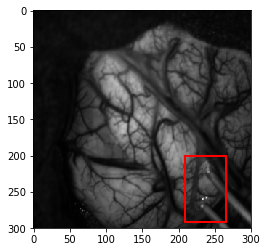

call transform
shape:(300, 300, 2)
[[143.      198.00002 174.      262.     ]]


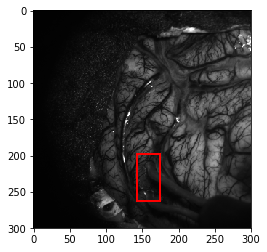

call transform
shape:(300, 300, 2)
[[235.00002  28.      274.       50.     ]]


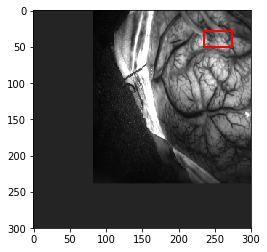

call transform
shape:(300, 300, 2)
[[238.      164.      300.      233.99998]]


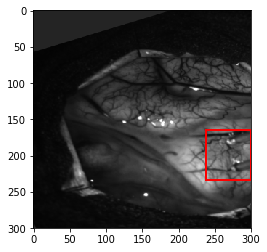

call transform
shape:(300, 300, 2)
[[198.00002 202.      238.      262.     ]]


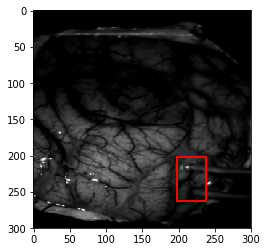

shape:(300, 300, 2)
[[ 23. 150.  45. 242.]]


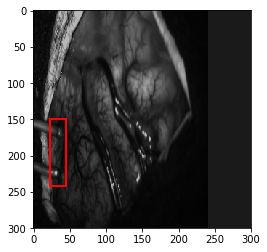

call transform
shape:(300, 300, 2)
[[109.      163.      127.00001 226.     ]]


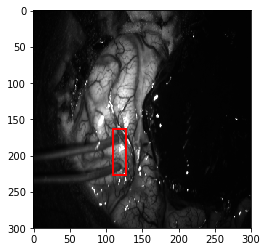

shape:(300, 300, 2)
[[171.      101.      214.      160.00002]]


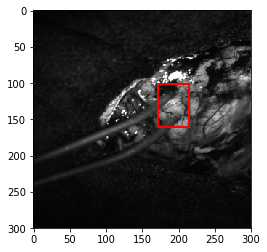

call transform
shape:(300, 300, 2)
[[ 27.000002  84.        97.       147.      ]]


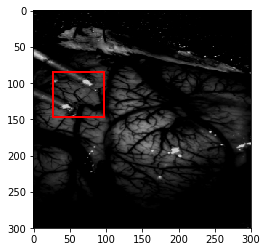

call transform
shape:(300, 300, 2)
[[179.00002 221.      200.      300.     ]]


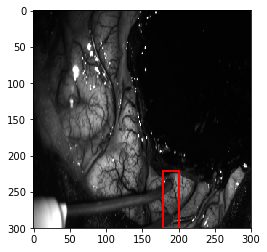

shape:(300, 300, 2)
[[121. 146. 162. 212.]]


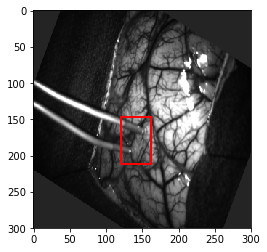

shape:(300, 300, 2)
[[100.  59. 142. 114.]]


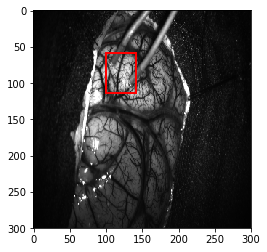

call transform
shape:(300, 300, 2)
[[166.       25.      199.       80.00001]]


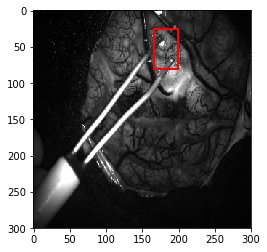

shape:(300, 300, 2)
[[185. 168. 227. 226.]]


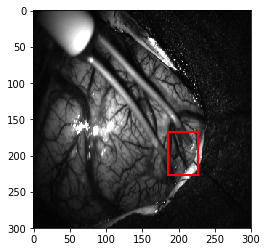

shape:(300, 300, 2)
[[ 96.       97.99999 150.      168.     ]]


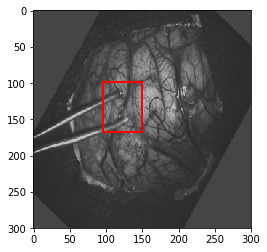

4.920650243759155 regression_loss: 4.093028052647909 classification_loss: 0.8276222149531046
7.2299968004226685val_loss: 6.455223083496094 val_classification_loss: 0.7747737169265747
lr: 1e-05
Epoch 1
call transform
shape:(300, 300, 2)
[[176.99998 169.      238.      252.99998]]


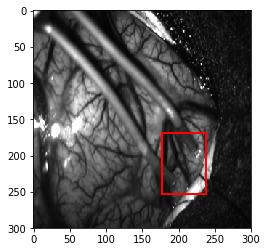

shape:(300, 300, 2)
[[103.      160.00002 127.00001 241.     ]]


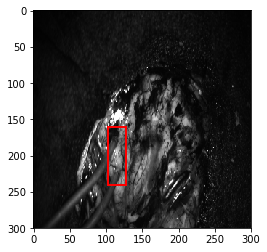

call transform
shape:(300, 300, 2)
[[139.  57. 169. 155.]]


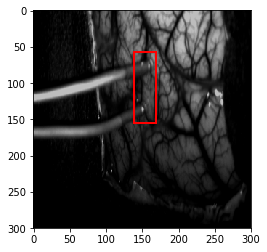

call transform
shape:(300, 300, 2)
[[107.  92. 145. 166.]]


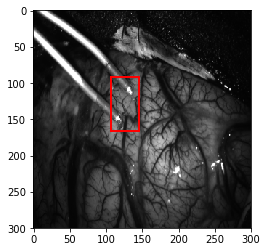

call transform
shape:(300, 300, 2)
[[139. 250. 144. 267.]]


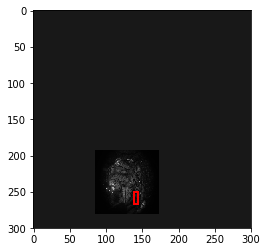

call transform
shape:(300, 300, 2)
[[176.99998 200.      223.      227.     ]]


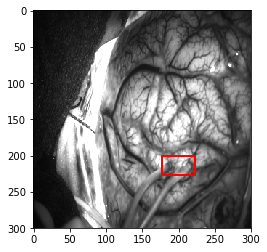

call transform
shape:(300, 300, 2)
[[127.00001  70.      155.      156.     ]]


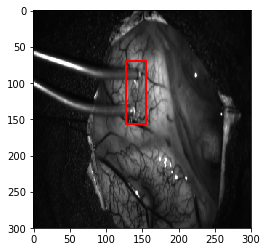

call transform
shape:(300, 300, 2)
[[ 41.        62.999996  93.       137.      ]]


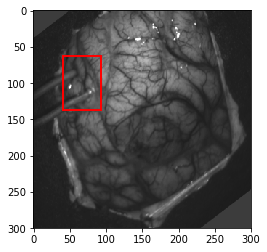

call transform
shape:(300, 300, 2)
[[ 78.  30. 147. 141.]]


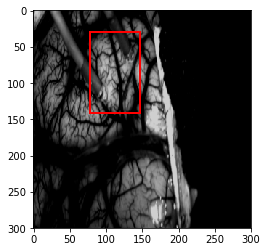

call transform
shape:(300, 300, 2)
[[104.  37. 141. 102.]]


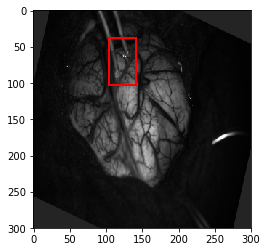

call transform
shape:(300, 300, 2)
[[268. 188. 291. 210.]]


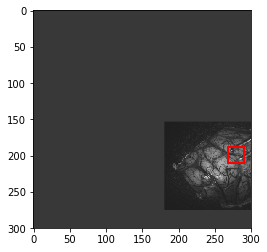

call transform
shape:(300, 300, 2)
[[172.  22. 218.  95.]]


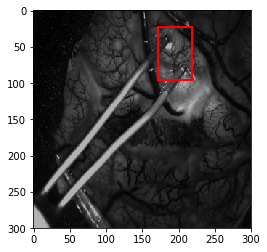

call transform
shape:(300, 300, 2)
[[268.      127.00001 299.      155.     ]]


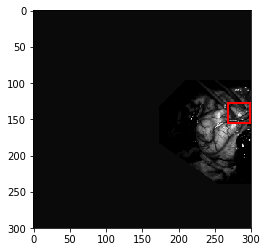

shape:(300, 300, 2)
[[156.      116.99999 201.      144.     ]]


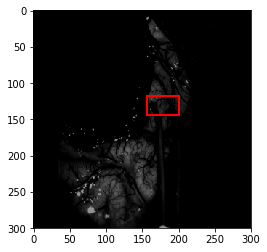

shape:(300, 300, 2)
[[108.00001 182.      176.      274.     ]]


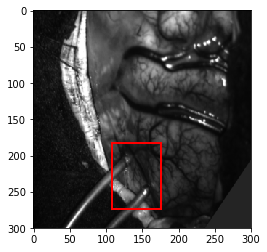

4.704993263880412 regression_loss: 3.931956346829732 classification_loss: 0.7730369408925374
7.245634913444519val_loss: 6.4748629331588745 val_classification_loss: 0.7707719951868057
lr: 2.053525026457146e-05
Epoch 2
call transform
call transform
shape:(300, 300, 2)
[[242.      219.      254.00002 250.     ]]


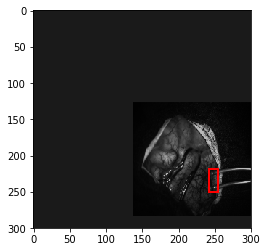

call transform
shape:(300, 300, 2)
[[198.00002   0.      267.       39.     ]]


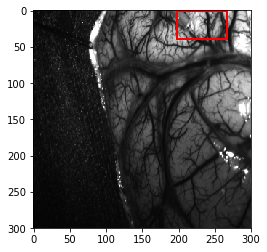

call transform
shape:(300, 300, 2)
[[197.00002  81.      244.      142.     ]]


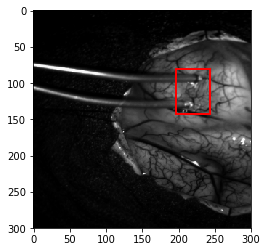

shape:(300, 300, 2)
[[ 22. 165.  29. 187.]]


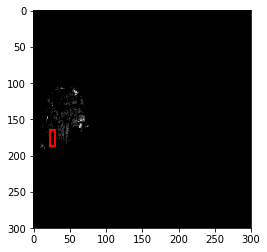

call transform
shape:(300, 300, 2)
[[118.  45. 135.  71.]]


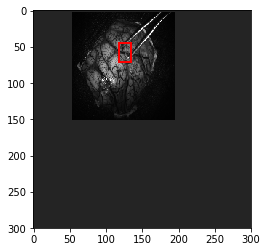

call transform
shape:(300, 300, 2)
[[139. 154. 164. 217.]]


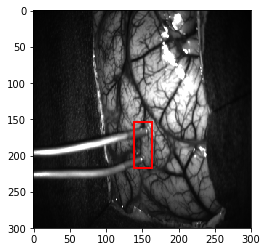

call transform
shape:(300, 300, 2)
[[205.      232.      230.      254.00002]]


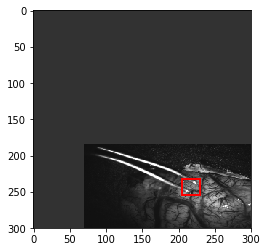

shape:(300, 300, 2)
[[131.      160.00002 175.      258.     ]]


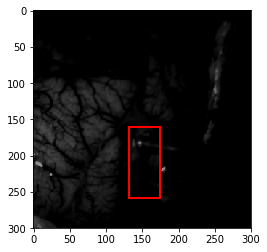

shape:(300, 300, 2)
[[148.      181.      197.00002 211.     ]]


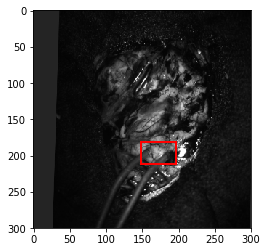

call transform
shape:(300, 300, 2)
[[ 97.      180.      125.99999 236.     ]]


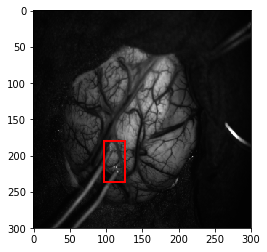

call transform
shape:(300, 300, 2)
[[141.   0. 188.  61.]]


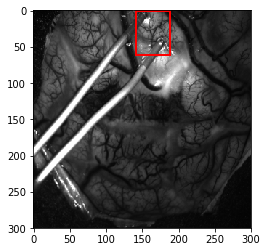

call transform
shape:(300, 300, 2)
[[ 12. 101.  75. 163.]]


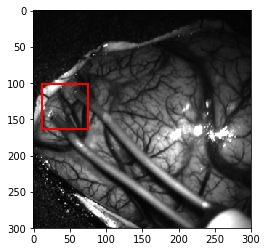

call transform
shape:(300, 300, 2)
[[216.00002 156.      226.      176.99998]]


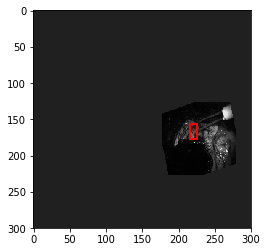

shape:(300, 300, 2)
[[185. 102. 205. 128.]]


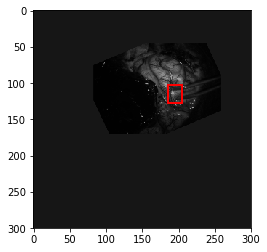

shape:(300, 300, 2)
[[142. 211. 193. 248.]]


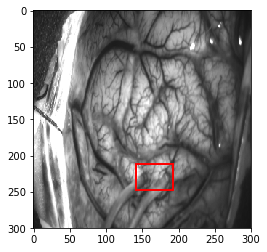

4.555079181989034 regression_loss: 3.811947472890218 classification_loss: 0.7431317567825317
7.2593711614608765val_loss: 6.511239767074585 val_classification_loss: 0.748131275177002
lr: 4.2169650342858216e-05
Epoch 3
call transform
call transform
call transform
shape:(300, 300, 2)
[[125.   9. 158.  60.]]


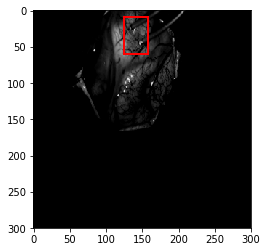

call transform
shape:(300, 300, 2)
[[160.00002 225.      180.      300.     ]]


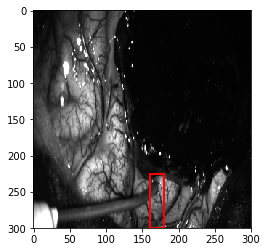

shape:(300, 300, 2)
[[233.   1. 300.  84.]]


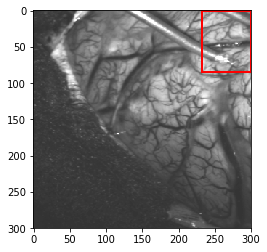

call transform
shape:(300, 300, 2)
[[ 79. 124. 194. 200.]]


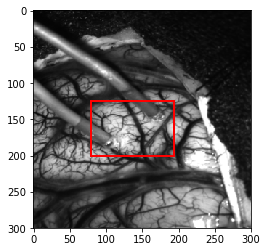

call transform
shape:(300, 300, 2)
[[124. 222. 209. 248.]]


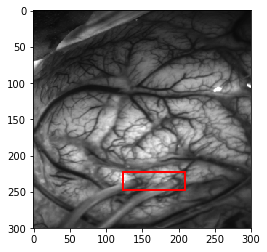

call transform
shape:(300, 300, 2)
[[ 87.      195.99998 123.      244.     ]]


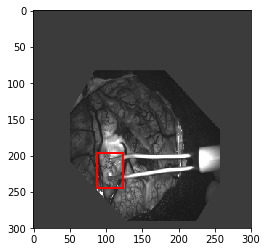

shape:(300, 300, 2)
[[248.       88.99999 275.      111.     ]]


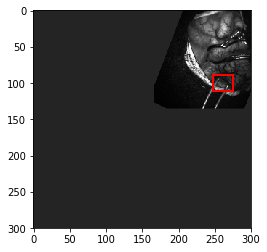

shape:(300, 300, 2)
[[ 88.99999 138.      118.      228.     ]]


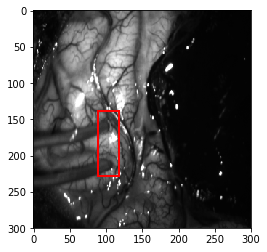

shape:(300, 300, 2)
[[237. 163. 291. 300.]]


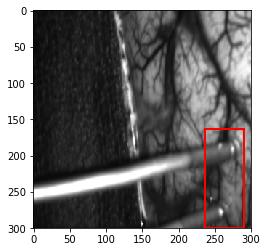

shape:(300, 300, 2)
[[ 94.        7.      156.      116.99999]]


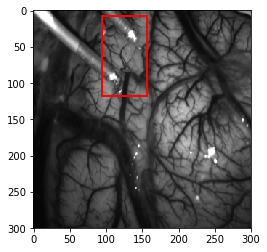

call transform
shape:(300, 300, 2)
[[ 85. 143. 115. 213.]]


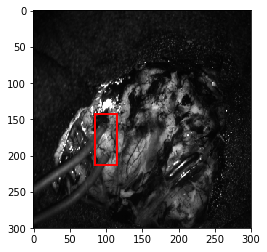

shape:(300, 300, 2)
[[119. 120. 169. 181.]]


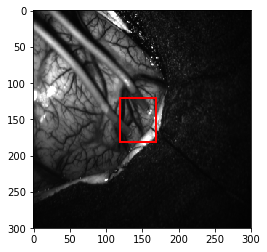

call transform
shape:(300, 300, 2)
[[ 88.99999 152.      188.      235.00002]]


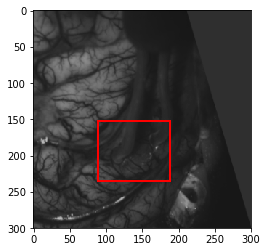

shape:(300, 300, 2)
[[ 23. 132.  64. 214.]]


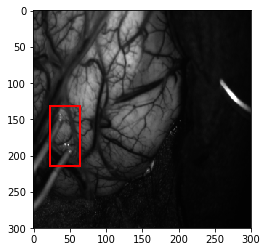

shape:(300, 300, 2)
[[  0. 201.  56. 264.]]


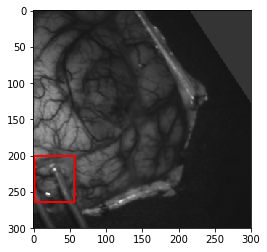

3.6842989762624105 regression_loss: 2.9813947598139445 classification_loss: 0.7029041747252146
7.132081627845764val_loss: 6.412258505821228 val_classification_loss: 0.7198233008384705
lr: 8.659643233600651e-05
Epoch 4
call transform
call transform
shape:(300, 300, 2)
[[132.      127.00001 174.      204.     ]]


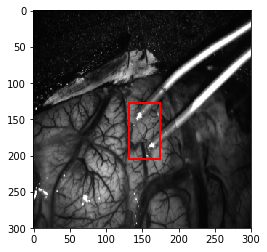

shape:(300, 300, 2)
[[ 80.00001 272.       87.      300.     ]]


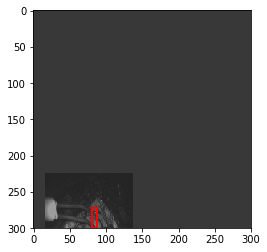

call transform
shape:(300, 300, 2)
[[198.00002   0.      267.       39.     ]]


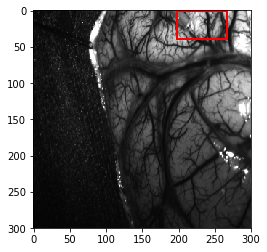

call transform
shape:(300, 300, 2)
[[151.      122.      192.      179.00002]]


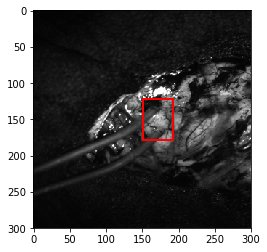

call transform
shape:(300, 300, 2)
[[218.      158.99998 239.      179.00002]]


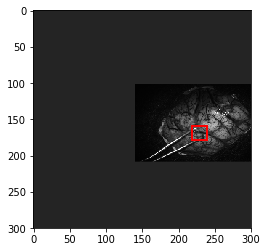

call transform
shape:(300, 300, 2)
[[146.      199.      198.00002 254.00002]]


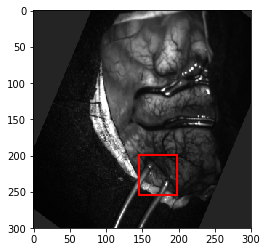

call transform
shape:(300, 300, 2)
[[ 97.  17. 134. 109.]]


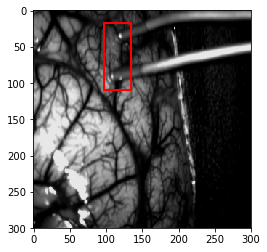

shape:(300, 300, 2)
[[113.      123.      127.00001 142.     ]]


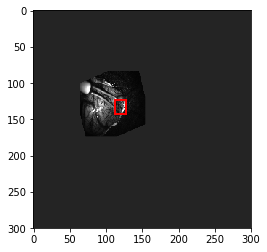

shape:(300, 300, 2)
[[ 83.       79.      177.99998 154.     ]]


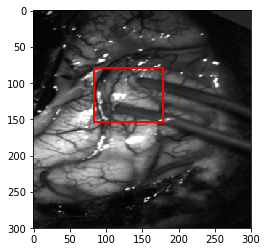

call transform
shape:(300, 300, 2)
[[108.00001 197.00002 131.      252.99998]]


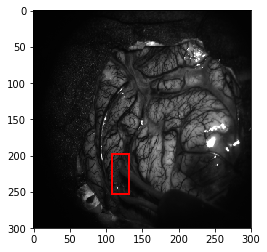

call transform
shape:(300, 300, 2)
[[203.  96. 255. 233.]]


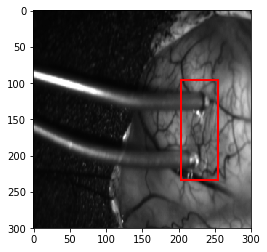

call transform
shape:(300, 300, 2)
[[ 91. 208. 134. 232.]]


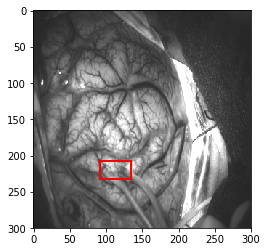

call transform
shape:(300, 300, 2)
[[  0. 120.  72. 226.]]


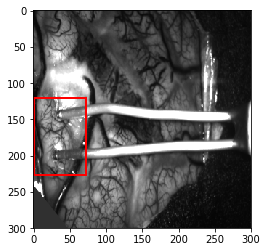

shape:(300, 300, 2)
[[258. 103. 275. 121.]]


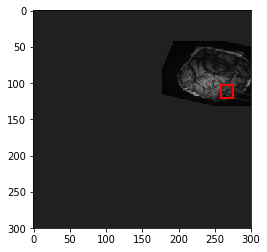

shape:(300, 300, 2)
[[188. 220. 200. 241.]]


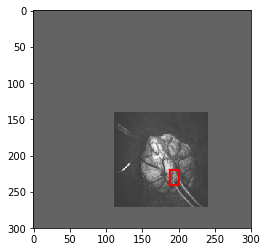

4.5028577963511145 regression_loss: 3.8335018714269 classification_loss: 0.6693559348583221
6.980533599853516val_loss: 6.03316056728363 val_classification_loss: 0.9473729580640793
lr: 0.00017782794100389222
Epoch 5
call transform
call transform
shape:(300, 300, 2)
[[106.       97.99999 156.      148.     ]]


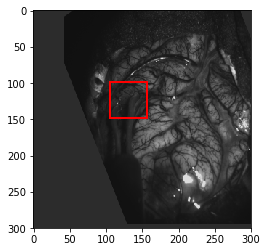

shape:(300, 300, 2)
[[133. 184. 176. 241.]]


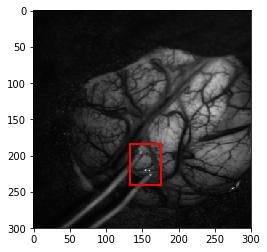

call transform
shape:(300, 300, 2)
[[181.   2. 261.  81.]]


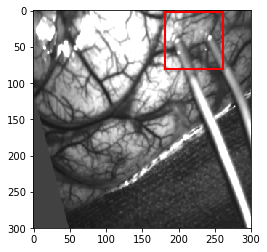

call transform
shape:(300, 300, 2)
[[268.  25. 300.  84.]]


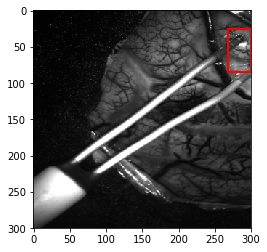

call transform
shape:(300, 300, 2)
[[ 36.      252.99998  45.      270.     ]]


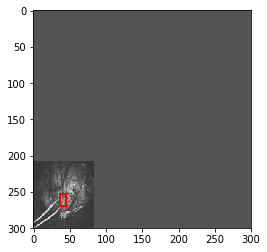

call transform
shape:(300, 300, 2)
[[125.99999  70.      162.      129.     ]]


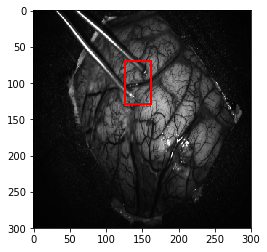

shape:(300, 300, 2)
[[174. 175. 186. 189.]]


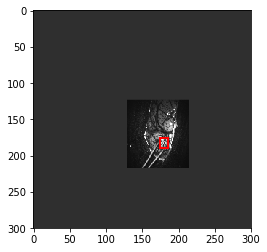

call transform
shape:(300, 300, 2)
[[224.       50.      289.      116.99999]]


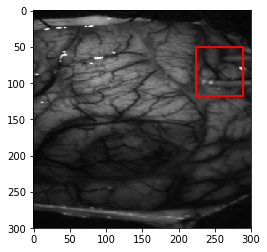

shape:(300, 300, 2)
[[114.  78. 190. 170.]]


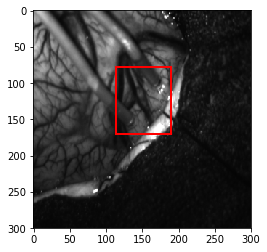

shape:(300, 300, 2)
[[200. 183. 256. 223.]]


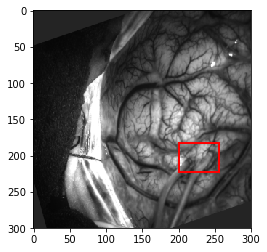

shape:(300, 300, 2)
[[ 99.00001 170.      121.      238.     ]]


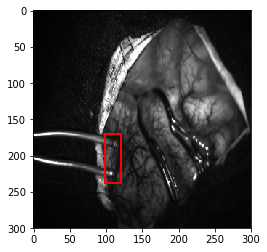

call transform
shape:(300, 300, 2)
[[ 61. 169.  86. 246.]]


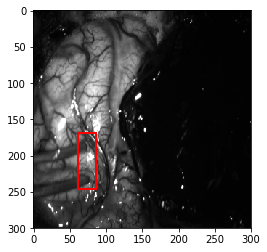

call transform
shape:(300, 300, 2)
[[ 20.000002 122.        58.       187.      ]]


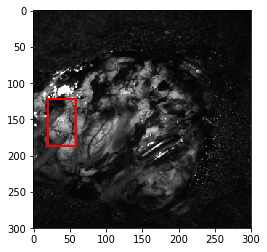

shape:(300, 300, 2)
[[ 97.99999 144.      145.      208.     ]]


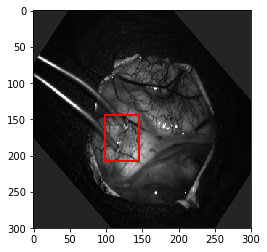

shape:(300, 300, 2)
[[275.  84. 300. 190.]]


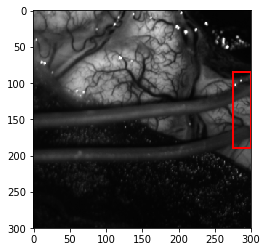

3.889815107981364 regression_loss: 3.354142729441325 classification_loss: 0.5356724063555399
9.988813638687134val_loss: 8.726444482803345 val_classification_loss: 1.2623690068721771
lr: 0.00036517412725483754
Epoch 6
call transform
call transform
shape:(300, 300, 2)
[[220. 226. 247. 276.]]


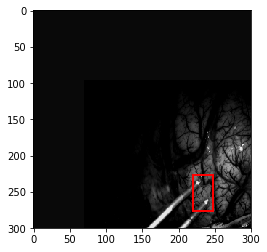

shape:(300, 300, 2)
[[ 97.99999 209.      105.      239.     ]]


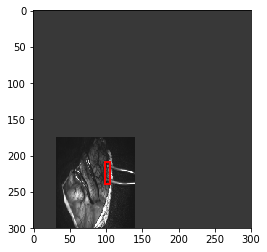

call transform
shape:(300, 300, 2)
[[160.00002  65.      183.      165.     ]]


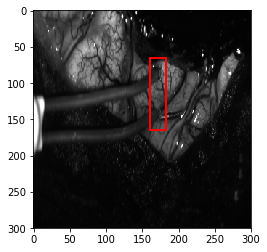

shape:(300, 300, 2)
[[ 91. 149. 124. 231.]]


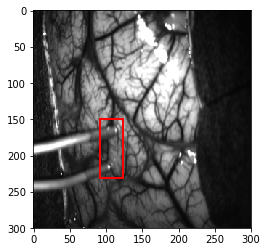

call transform
shape:(300, 300, 2)
[[173. 131. 194. 184.]]


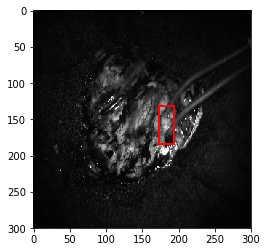

call transform
shape:(300, 300, 2)
[[116. 146. 135. 211.]]


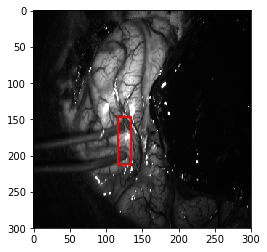

call transform
shape:(300, 300, 2)
[[ 67. 295.  81. 300.]]


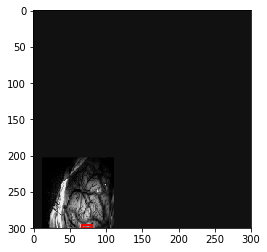

call transform
shape:(300, 300, 2)
[[ 75. 165. 131. 223.]]


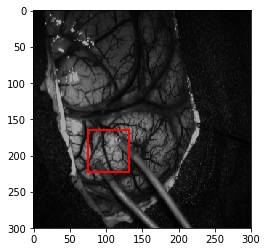

call transform
shape:(300, 300, 2)
[[173.  15. 208.  73.]]


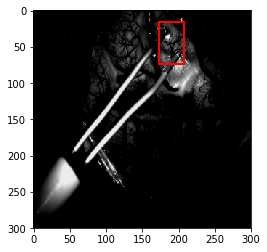

call transform
shape:(300, 300, 2)
[[ 59. 129. 102. 195.]]


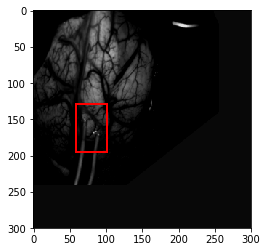

call transform
shape:(300, 300, 2)
[[101.       99.00001 136.      148.     ]]


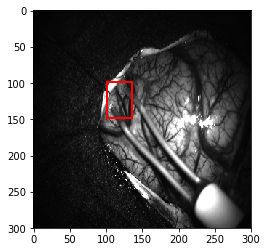

call transform
shape:(300, 300, 2)
[[ 64. 230. 106. 300.]]


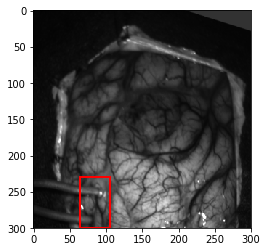

call transform
shape:(300, 300, 2)
[[147. 168. 206. 200.]]


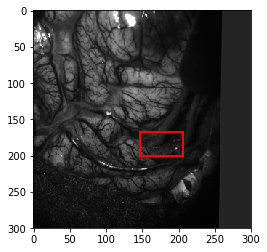

shape:(300, 300, 2)
[[188.  73. 205. 105.]]


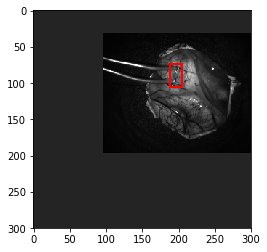

shape:(300, 300, 2)
[[237.  74. 300. 133.]]


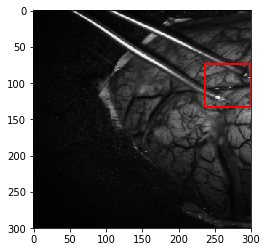

6.239931233723959 regression_loss: 5.658616511027018 classification_loss: 0.5813147346178691
25.680641651153564val_loss: 24.071759462356567 val_classification_loss: 1.6088819801807404
lr: 0.0007498942093324554
Epoch 7
call transform
call transform
call transform
shape:(300, 300, 2)
[[101. 118. 149. 190.]]


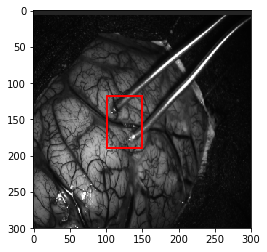

call transform
shape:(300, 300, 2)
[[106. 145. 145. 217.]]


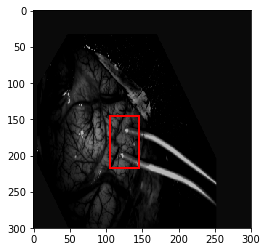

call transform
shape:(300, 300, 2)
[[149. 141. 205. 232.]]


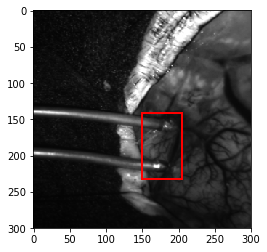

call transform
shape:(300, 300, 2)
[[  6. 161.  53. 207.]]


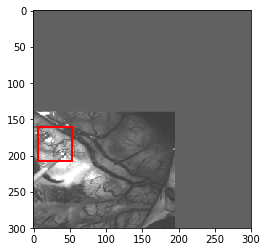

call transform
shape:(300, 300, 2)
[[  4.      121.       46.      177.99998]]


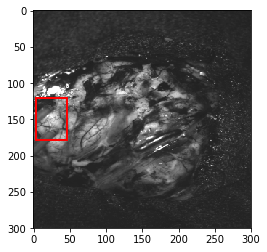

shape:(300, 300, 2)
[[173.  85. 195. 145.]]


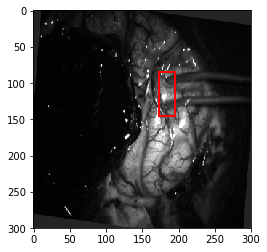

shape:(300, 300, 2)
[[153. 164. 188. 237.]]


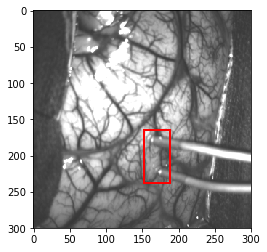

call transform
shape:(300, 300, 2)
[[ 85.   0. 119.  48.]]


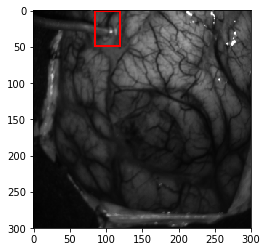

call transform
shape:(300, 300, 2)
[[113. 248. 137. 300.]]


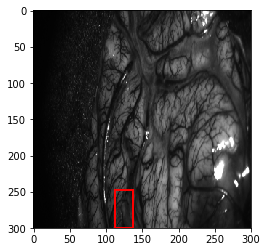

call transform
shape:(300, 300, 2)
[[139. 184. 171. 206.]]


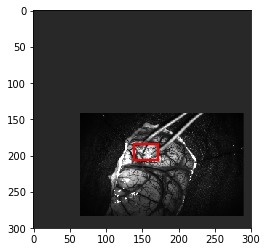

call transform
shape:(300, 300, 2)
[[230.      225.      295.      254.00002]]


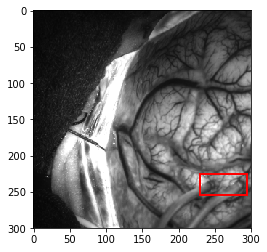

call transform
shape:(300, 300, 2)
[[129. 146. 146. 164.]]


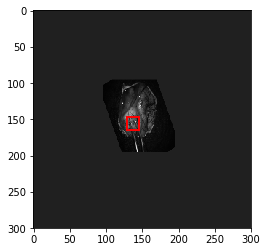

call transform
shape:(300, 300, 2)
[[ 95. 183. 162. 272.]]


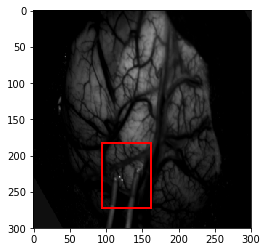

shape:(300, 300, 2)
[[237. 172. 275. 218.]]


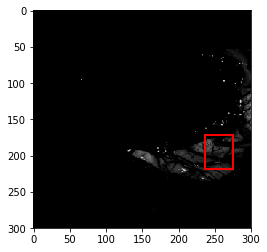

shape:(300, 300, 2)
[[193.      116.99999 208.      136.     ]]


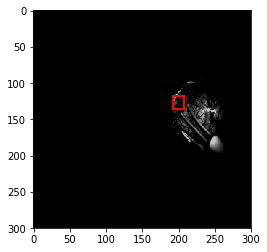

5.522974443435669 regression_loss: 4.95946950117747 classification_loss: 0.5635049084822337
10.658174753189087val_loss: 9.004699230194092 val_classification_loss: 1.6534754931926727
lr: 0.001539926526059491
Epoch 8
call transform
call transform
shape:(300, 300, 2)
[[114.  56. 175. 148.]]


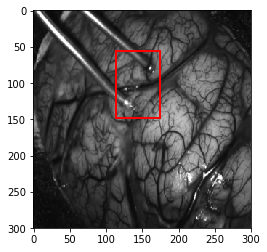

call transform
shape:(300, 300, 2)
[[213. 193. 238. 228.]]


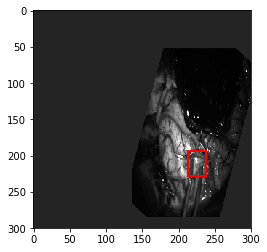

call transform
shape:(300, 300, 2)
[[168.        54.000004 213.       139.      ]]


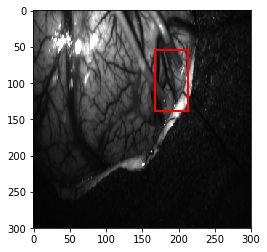

call transform
shape:(300, 300, 2)
[[ 21. 223.  44. 293.]]


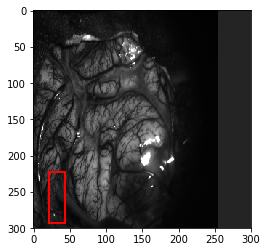

call transform
shape:(300, 300, 2)
[[120. 139. 167. 203.]]


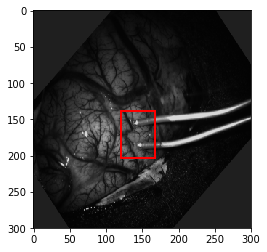

call transform
shape:(300, 300, 2)
[[106. 213. 141. 276.]]


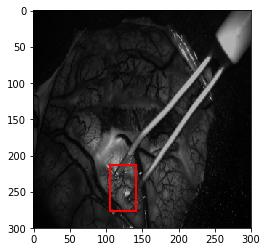

shape:(300, 300, 2)
[[156.  65. 187. 132.]]


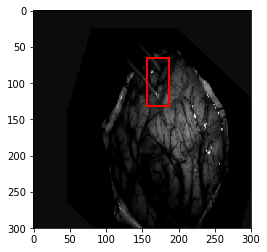

call transform
shape:(300, 300, 2)
[[135.       87.      200.      160.00002]]


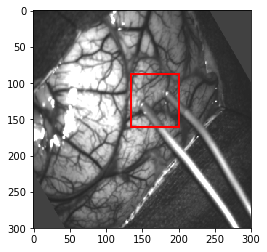

call transform
shape:(300, 300, 2)
[[ 30.   1.  71. 136.]]


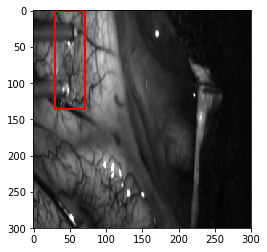

shape:(300, 300, 2)
[[ 71. 134. 111. 206.]]


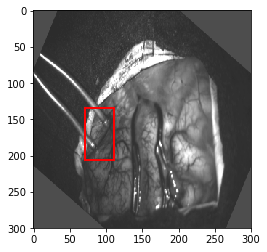

shape:(300, 300, 2)
[[132. 180. 168. 203.]]


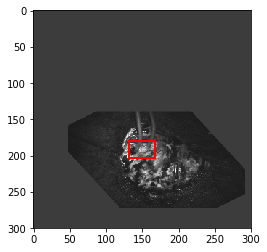

call transform
shape:(300, 300, 2)
[[ 64. 201. 172. 231.]]


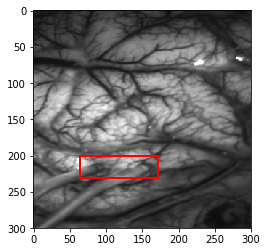

call transform
shape:(300, 300, 2)
[[108.00001 258.      138.      300.     ]]


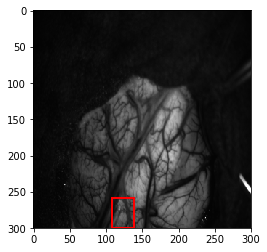

shape:(300, 300, 2)
[[124.  84. 143. 142.]]


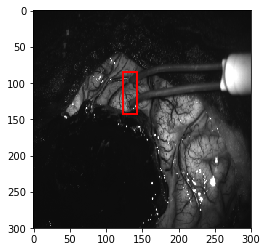

shape:(300, 300, 2)
[[158.99998  59.      201.      115.     ]]


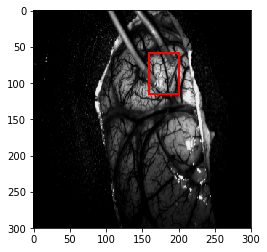

10.827167193094889 regression_loss: 9.909128856658935 classification_loss: 0.9180383245150249
39.44814968109131val_loss: 37.7089239358902 val_classification_loss: 1.7392260134220123
lr: 0.0031622776601683772
Epoch 9
call transform
call transform
call transform
shape:(300, 300, 2)
[[156. 106. 203. 193.]]


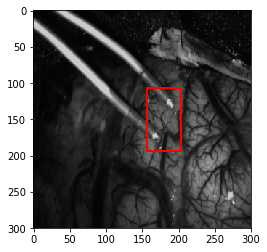

call transform
shape:(300, 300, 2)
[[243. 210. 275. 244.]]


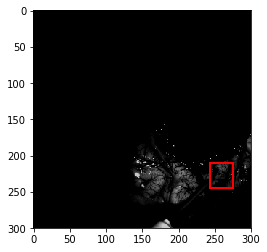

call transform
shape:(300, 300, 2)
[[190.  77. 203. 119.]]


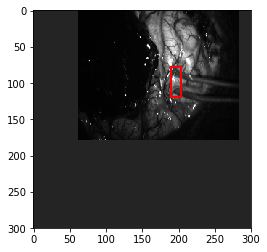

call transform
shape:(300, 300, 2)
[[202.  19. 218.  38.]]


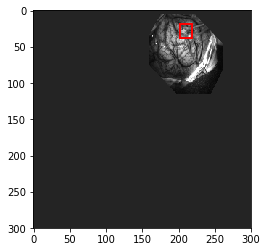

call transform
shape:(300, 300, 2)
[[ 70.      233.99998 108.00001 300.     ]]


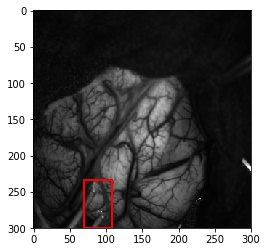

call transform
shape:(300, 300, 2)
[[  0.       164.        48.999996 248.      ]]


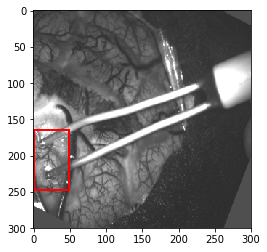

call transform
shape:(300, 300, 2)
[[112.      213.      160.00002 262.     ]]


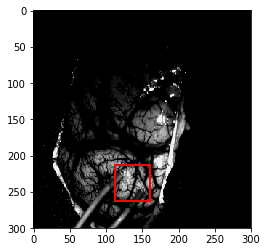

call transform
shape:(300, 300, 2)
[[ 39.        20.000002  72.       107.      ]]


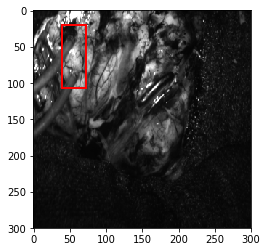

call transform
shape:(300, 300, 2)
[[ 19.       50.       74.      125.99999]]


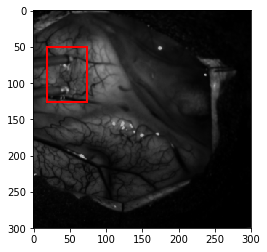

call transform
shape:(300, 300, 2)
[[118.  50. 141. 105.]]


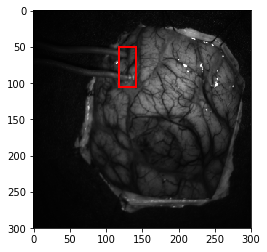

shape:(300, 300, 2)
[[149.       26.      216.00002  84.     ]]


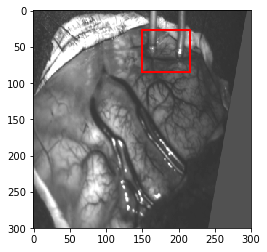

call transform
shape:(300, 300, 2)
[[  0. 243.  41. 277.]]


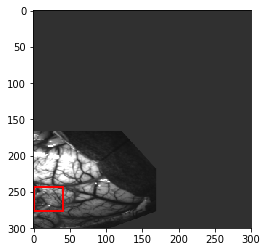

call transform
shape:(300, 300, 2)
[[133.       26.      231.      116.99999]]


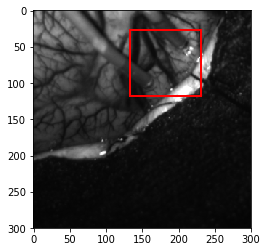

shape:(300, 300, 2)
[[168.      260.      179.00002 280.     ]]


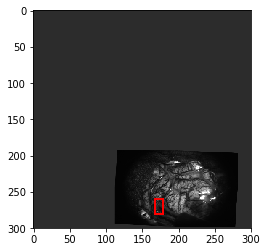

shape:(300, 300, 2)
[[134.  88. 202. 156.]]


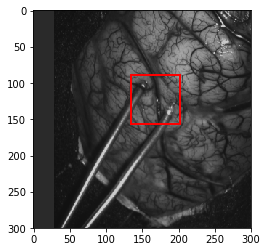

16.193104839324953 regression_loss: 14.512223164240519 classification_loss: 1.6808818141619364
21.305680990219116val_loss: 19.219499349594116 val_classification_loss: 2.0861815214157104
lr: 0.006493816315762107


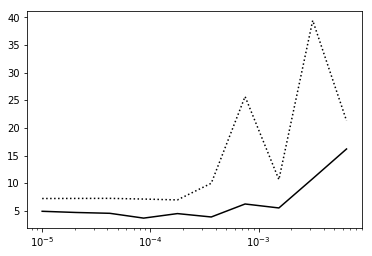

In [18]:
lrs, losses, val_losses = find_lr(train_loader, val_loader, net, start_lr, max_lr, num_epochs, optimizer)
#file_name = str(start_lr) + "_" + str(max_lr) + "_losses.txt"
#with open(file_name, "wb") as fp:
#    pickle.dump([lrs, losses], fp)
    
#plt.plot(lrs, losses, 'b-')
plt.semilogx(lrs, losses, 'k-')
plt.semilogx(lrs, val_losses, 'k:')

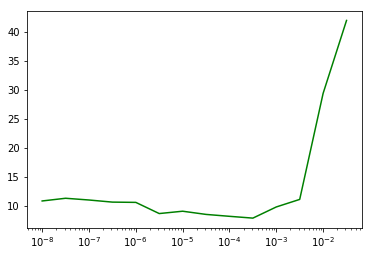

In [17]:
plt.semilogx(lrs, losses, 'g-')

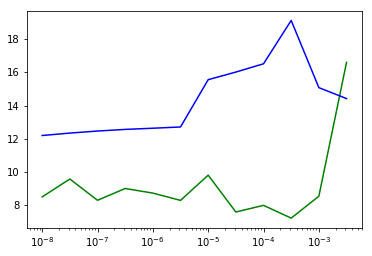

In [31]:
plt.semilogx(lrs[:-2], losses[:-2], 'g-')
plt.semilogx(lrs[:-2], val_losses[:-2], 'b-')

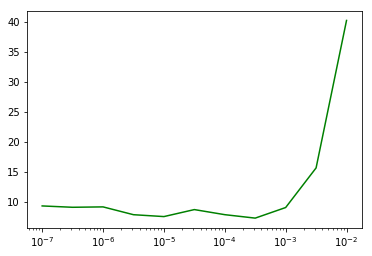

In [15]:
plt.semilogx(lrs, losses, 'g-')

In [ ]:
def find_lr(train_loader, test_loader, model, start_lr, max_lr, num_epochs, opt):
#     import pdb; pdb.set_trace()

    n = 16 # number of iterations
    q = (max_lr / start_lr)**(1./n)
    sched = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma=q) #torch.optim.lr_scheduler.ExponentialLR(opt, gamma)
    losses = []
    lrs = []
    val_losses = []
    best_loss = 10**10
    for epoch in range(0, num_epochs):
        print("Epoch " + str(epoch))
        sched.step()
        loss, regression_loss, classification_loss = train(train_loader, net, criterion, optimizer,
              device=DEVICE, debug_steps=10, epoch=epoch)
        
        print(str(loss) +" regression_loss: " + str(regression_loss) + " classification_loss: " + str(classification_loss))
        val_loss, val_regression_loss, val_classification_loss = test(val_loader, net, criterion, DEVICE)
        print(str(val_loss) + "val_loss: " + str(val_regression_loss) + " val_classification_loss: " + str(val_classification_loss))
        
        lrs.append(sched.get_lr()[0])
        losses.append(loss)
        val_losses.append(val_loss)
        
        print("lr: " + str(sched.get_lr()[0]))
        
        if loss < best_loss:
            best_loss = loss
        
        if loss > 4*best_loss:
            break
            
    return lrs, losses, val_losses